In [1]:
## Imports
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Draw inline
%matplotlib inline

# Set figure aesthetics
plt.style.use('ggplot')
#sns.set_style("whitegrid", {'ytick.major.size': 10.0})
sns.set_context("talk", font_scale=1.1)

In [54]:
import json
from pandas.io.json import json_normalize

data = json.load((open('G:\Datasets\StudentLife\dataset\EMA\EMA_definition.json')))

#### Read in EMA Question Definitions

In [159]:
EMA_definitions = json_normalize(data,'questions',['name'])
EMA_definitions[EMA_definitions['name']=='Exercise']

,options,question_id,question_text,name
31,(Yes) 1 2 (No),have,Did you do vigorous exercise today (don't incl...,Exercise
32,(Yes) 1 2 (No),schedule,If no did you want to but couldn't because of ...,Exercise
33,"[1]None, [2]<30 mins, [3]30-60 mins, [4]60-90 ...",exercise,If you exercised how long did you exercise for?,Exercise
34,,location,,Exercise
35,"[1]None, [2]<30 mins, [3]30-60 mins, [4]60-90 ...",walk,How long did you walk for today?,Exercise


#### Start reading in responses

- Locate Directory
- Get list of files
- Creat DataFrame
- Iterate over files, appending to Master DataFrame
- Group by User and Resample, Process to Create Exercise_Features

In [337]:
import os

def EMA_extractor(Question):
    
    # Set up filenames
    EMA_root_directory = r'G:\Datasets\StudentLife\dataset\EMA\response'
    foldername = os.path.join(EMA_root_directory,Question)
#    print('foldername:',foldername)
    filenames = os.listdir(foldername)
    
    # Create Initial Dataframe with first student
    student_id = filenames[0][-8:-5]
    file = os.path.join(EMA_root_directory,Question,filenames[0])

    df = pd.read_json(file)
    df['id'] = student_id


    # Iterate over the rest of students
    for filename in filenames[1:]:
        student_id = filename[-8:-5]
        file = os.path.join(EMA_root_directory,Question,filename)

        df_student = pd.read_json(file)
        df_student['id'] = student_id

        df = pd.concat([df,df_student],ignore_index=True)
    
    return df

#### Extract Each File/EMA Question + Preprocess

In [ ]:
Questions = ['Social','Stress','Sleep','Exercise','Mood','Mood1','Mood2']


In [345]:
# EXERCISE
df = EMA_extractor('Exercise')

#Clean-up
Exercise_df = df
Exercise_df['have'] = Exercise_df['have'].replace('null',np.nan).astype(float)
Exercise_df['schedule'] = Exercise_df['schedule'].replace('null',np.nan).astype(float)
Exercise_df.drop('location',axis=1,inplace=True)
Exercise_df.set_index('resp_time',inplace=True)
Exercise_df = Exercise_df[Exercise_df.index < pd.to_datetime('2013-06-09')]

In [353]:
Exercise_df.head()

,exercise,have,id,schedule,walk
resp_time,,,,,
2013-04-03 03:43:26,4,1,u00,NaN,2
2013-04-01 14:55:38,3,2,u00,1,2
2013-04-01 17:12:56,1,2,u00,1,1
2013-04-02 04:03:53,1,1,u00,NaN,1
2013-04-04 00:28:03,1,2,u00,1,2


In [351]:
# STRESS
df = EMA_extractor('Stress')
df.drop(['location','null'],axis=1,inplace=True)
Stress_df = df

In [355]:
Stress_df.tail()

,id,level,resp_time
2403,u59,4,2013-06-02 21:31:46
2404,u59,4,2013-06-03 03:48:30
2405,u59,4,2013-06-05 01:09:43
2406,u59,4,2013-06-06 10:22:12
2407,u59,4,2013-06-07 23:46:27


In [362]:
# SOCIAL
df = EMA_extractor('Social')
df.drop(['location','null'],axis=1,inplace=True)
Social_df = df

In [363]:
Social_df.tail()

,id,number,resp_time
1405,u59,4,2013-05-26 19:17:44
1406,u59,3,2013-06-06 00:05:53
1407,u59,4,2013-06-02 06:00:24
1408,u59,3,2013-06-04 23:18:09
1409,u59,3,2013-06-07 23:46:31


In [367]:
# SLEEP
df = EMA_extractor('Sleep')
df.drop(['location','null'],axis=1,inplace=True)
Sleep_df = df

In [368]:
Sleep_df.tail()

,hour,id,rate,resp_time,social
1639,15,u59,1,2013-06-06 00:06:14,1
1640,19,u59,1,2013-06-02 21:30:45,1
1641,1,u59,3,2013-06-02 06:00:37,3
1642,13,u59,1,2013-06-04 23:18:02,1
1643,5,u59,2,2013-06-07 23:46:41,3


In [375]:
# MOOD (2 binary questions on happy/sad, two scale 1-4)
df = EMA_extractor('Mood')
df.drop(['location'],axis=1,inplace=True)
df[['happyornot','sadornot']] = df[['happyornot','sadornot']].replace('null',np.nan).astype(float)
Mood_df = df

# MOOD 1 (How do you think you will be tomorrow?  1: Happy, 2: Stressed, 3: Tired)
df = EMA_extractor('Mood 1')
df.drop(['location'],axis=1,inplace=True)
Mood1_df = df

# MOOD 2 (Categorical: How are you right now? 1: Happy, 2: Stressed, 3: Tired)

df = EMA_extractor('Mood 2')
df.drop(['location','null'],axis=1,inplace=True)
Mood2_df = df

In [387]:
EMA_DFs = [Social_df,Stress_df,Sleep_df,Exercise_df,Mood_df,Mood1_df,Mood2_df]


### Activity Sensing (Totals)

In [613]:
foldername = r'G:\Datasets\StudentLife\dataset\sensing\activity'
filenames = os.listdir(foldername)

# Create Initial Dataframe with first student
file = os.path.join(foldername,filenames[0])

#Function for reading in file
df = activities_totals(file)

# Iterate over the rest of students
for filename in filenames[1:]:
    file = os.path.join(foldername,filename)

    df_student = activities_totals(file)
    df = pd.concat([df,df_student])

Activity_df = df    

foldername: G:\Datasets\StudentLife\dataset\sensing\activity


In [612]:
def activities_totals(file):
    student_id = file[-7:-4]
    
    act = pd.read_csv(file,parse_dates=['timestamp'])
    act['timestamp'] = pd.to_datetime(act['timestamp'].astype(int),unit='s')
    act.set_index('timestamp',inplace=True)
    act.rename(columns={act.columns[0]:'activity_inference'},inplace=True)
    
    act = act['activity_inference'].astype("category")
    act5 = (pd.get_dummies(act).resample('5T',how='mean')>0.5).astype(int)

    act_totals = pd.DataFrame(act5.sum(axis=0)/12).T
    act_totals.rename(index={0:student_id},columns={0:'Stationary',1:'Walking',2:'Running',3:'Unknown'},inplace=True)
    #act_totals_percent = act_totals.divide(act_totals.sum(axis=1),axis=0)
    act_totals['hours_logged'] = act_totals.sum(axis=1)
    return act_totals

In [631]:
act_p = Activity_df[Activity_df.columns[0:4]].divide(Activity_df['hours_logged'],axis=0).rename(columns=lambda x: x+'_p')
Activity_df = pd.merge(act_p,Activity_df,left_index=True,right_index=True,how='outer')

In [633]:
Activity_df.head()

,Stationary_p,Walking_p,Running_p,Unknown_p,Stationary,Walking,Running,Unknown,hours_logged
u00,0.889,0.062,0.017,0.032,1203.500,84.000,22.917,43.167,1353.583
u01,0.945,0.034,0.017,0.004,1309.750,47.167,23.750,5.917,1386.583
u02,0.931,0.056,0.001,0.012,1437.167,85.833,1.000,19.083,1543.083
u03,0.986,0.011,0.001,0.002,1173.417,13.333,1.167,2.583,1190.500
u04,0.877,0.065,0.031,0.028,1171.500,86.833,40.750,36.750,1335.833


In [645]:
Exercise_df

,exercise,have,id,schedule,walk
resp_time,,,,,
2013-04-03 03:43:26,4.000,1.000,u00,nan,2.000
2013-04-01 14:55:38,3.000,2.000,u00,1.000,2.000
2013-04-01 17:12:56,1.000,2.000,u00,1.000,1.000
2013-04-02 04:03:53,1.000,1.000,u00,nan,1.000
2013-04-04 00:28:03,1.000,2.000,u00,1.000,2.000
2013-04-04 02:03:44,1.000,2.000,u00,1.000,3.000
2013-04-06 02:19:21,1.000,2.000,u00,1.000,1.000
2013-04-05 02:39:51,4.000,1.000,u00,2.000,3.000
2013-04-05 20:37:51,4.000,1.000,u00,nan,3.000


In [649]:
ex = Exercise_df.groupby('id').mean()['have']

In [648]:
Exercise_df.groupby('id').mean()

,exercise,have,schedule,walk
id,,,,
u00,2.028,1.657,1.222,1.722
u01,1.000,2.000,2.000,2.429
u02,2.000,1.500,1.909,2.417
u03,1.875,1.875,2.000,2.125
u04,4.083,1.000,1.857,2.583
u07,2.385,1.615,1.846,2.308
u08,1.516,1.806,1.080,2.419
u10,1.700,1.700,1.071,2.100
u12,2.000,1.556,1.375,1.889


In [644]:
Activity_df['Walking'].corr(ex)

-0.017955426776457034

In [650]:
Activity_df['Running_p'].corr(ex)

0.021465120808379142

In [623]:
pd.options.display.float_format = '{:.3f}'.format
(df*100).describe()

,Stationary,Walking,Running,Unknown,hours_logged
count,49.000,49.000,49.000,49.000,49.000
mean,117062.755,4729.422,1159.864,2252.721,125204.762
std,25394.618,2565.098,1847.961,1595.936,26992.247
min,46941.667,141.667,0.000,150.000,47233.333
25%,104333.333,2666.667,225.000,1000.000,112633.333
50%,123133.333,4275.000,550.000,2008.333,134725.000
75%,135850.000,6750.000,1275.000,2841.667,145908.333
max,147316.667,11041.667,11766.667,8300.000,155425.000


In [601]:
activities_totals(file)

,Stationary,Walking,Running,Unknown
u00,0.889121,0.062058,0.01693,0.031891


In [594]:
    act = pd.read_csv(file,parse_dates=['timestamp'])
    act['timestamp'] = pd.to_datetime(act['timestamp'].astype(int),unit='s')
    act.set_index('timestamp',inplace=True)
    act.rename(columns={act.columns[0]:'activity_inference'},inplace=True)
    act

,activity_inference
timestamp,
2013-03-27 04:00:01,0
2013-03-27 04:00:04,0
2013-03-27 04:00:07,0
2013-03-27 04:00:09,0
2013-03-27 04:03:12,0
2013-03-27 04:03:15,0
2013-03-27 04:03:17,0
2013-03-27 04:03:20,0
2013-03-27 04:03:22,0


In [599]:
act = act['activity_inference'].astype("category")
act5 = (pd.get_dummies(act).resample('5T',how='mean')>0.5).astype(int)
act5

,0,1,2,3
timestamp,,,,
2013-03-27 04:00:00,1,0,0,0
2013-03-27 04:05:00,1,0,0,0
2013-03-27 04:10:00,1,0,0,0
2013-03-27 04:15:00,1,0,0,0
2013-03-27 04:20:00,1,0,0,0
2013-03-27 04:25:00,1,0,0,0
2013-03-27 04:30:00,1,0,0,0
2013-03-27 04:35:00,1,0,0,0
2013-03-27 04:40:00,1,0,0,0


In [610]:
act_totals

,Stationary,Walking,Running,Unknown
u00,0.89,0.06,0.02,0.03


In [550]:
## Process
act = pd.read_csv(file,parse_dates=['timestamp'])
act['timestamp'] = pd.to_datetime(act['timestamp'].astype(int),unit='s')
act.set_index('timestamp',inplace=True)
act.rename(columns={act.columns[0]:'activity_inference'},inplace=True)

In [578]:
activities_totals(file)

,Stationary,Walking,Running,Unknown
u00,0.889121,0.062058,0.01693,0.031891


In [572]:
act_totals = pd.DataFrame(act5.sum(axis=0)/12).T
act_totals.rename(index={0:'u00'},columns={0:'Stationary',1:'Walking',2:'Running',3:'Unknown'},inplace=True)
act_totals = act_totals.divide(act_totals.sum(axis=1),axis=0)
act_totals

,Stationary,Walking,Running,Unknown
u00,0.889121,0.062058,0.01693,0.031891


In [547]:
foldername = r'G:\Datasets\StudentLife\dataset\sensing\activity'
#foldername = os.path.join(EMA_root_directory,Question)
print('foldername:',foldername)
filenames = os.listdir(foldername)


foldername: G:\Datasets\StudentLife\dataset\sensing\activity


In [548]:
os.path.join(foldername,filenames[0])

'G:\\Datasets\\StudentLife\\dataset\\sensing\\activity\\activity_u00.csv'

In [492]:
ac_st = ac_st['activity_inference'].astype("category")

In [546]:
(ac_st==0).resample('5T',how='max').sum()/60

262.81666666666666

In [478]:
(ac_st==1).resample('1T',how='max').sum()/60

activity_inference    82.95
dtype: float64

In [477]:
(ac_st==3).resample('1T',how='max').sum()/60

activity_inference    58.1
dtype: float64

In [476]:
(ac_st==2).resample('1T',how='max').sum()/60

activity_inference    20.983333
dtype: float64

In [491]:
ac_st.resample('1T',how='mean').count()/60

activity_inference    661.066667
dtype: float64

In [488]:
94864/60

1581.0666666666666

In [486]:
60*24

1440

In [515]:
AA = (pd.get_dummies(ac_st).resample('5T',how='mean')>0.5).astype(int)
AA

,0,1,2,3
timestamp,,,,
2013-03-27 04:00:00,1,0,0,0
2013-03-27 04:05:00,1,0,0,0
2013-03-27 04:10:00,1,0,0,0
2013-03-27 04:15:00,1,0,0,0
2013-03-27 04:20:00,1,0,0,0
2013-03-27 04:25:00,1,0,0,0
2013-03-27 04:30:00,1,0,0,0
2013-03-27 04:35:00,1,0,0,0
2013-03-27 04:40:00,1,0,0,0


In [545]:
AAA = (pd.DataFrame(AA.sum()/12).T)
AAA.rename(index={0:'u00'},columns={0:'Stationary',1:'Walking',2:'Running',3:'Unknown'},inplace=True)
AAA.divide(AAA.sum(axis=1),axis=0)*100

,Stationary,Walking,Running,Unknown
u00,88.912147,6.20575,1.693037,3.189066


In [528]:
AAAA

,0,1,2,3
timestamp,,,,
2013-03-31,89.416667,8.416667,3.333333,1.500000
2013-04-07,148.083333,8.250000,4.666667,3.416667
2013-04-14,153.000000,7.333333,2.583333,2.500000
2013-04-21,143.166667,8.333333,2.166667,7.416667
2013-04-28,137.666667,8.000000,4.333333,3.583333
2013-05-05,110.750000,15.250000,1.583333,4.500000
2013-05-12,140.083333,10.833333,1.750000,6.166667
2013-05-19,112.333333,6.416667,0.166667,7.583333
2013-05-26,81.416667,4.750000,0.000000,3.750000


In [530]:
AAAA = AA.resample('W',how='sum')/12
AAAA.sum(axis=1)
AAAA.divide(AAAA.sum(axis=1),axis=0)*100

,0,1,2,3
timestamp,,,,
2013-03-31,87.094156,8.198052,3.246753,1.461039
2013-04-07,90.065890,5.017739,2.838317,2.078054
2013-04-14,92.493703,4.433249,1.561713,1.511335
2013-04-21,88.877393,5.173306,1.345059,4.604242
2013-04-28,89.636462,5.208899,2.821487,2.333152
2013-05-05,83.848580,11.545741,1.198738,3.406940
2013-05-12,88.195173,6.820567,1.101784,3.882476
2013-05-19,88.801054,5.072464,0.131752,5.994730
2013-05-26,90.546803,5.282669,0.000000,4.170528


In [529]:
AAAA.sum(axis=1)

timestamp
2013-03-31    102.666667
2013-04-07    164.416667
2013-04-14    165.416667
2013-04-21    161.083333
2013-04-28    153.583333
2013-05-05    132.083333
2013-05-12    158.833333
2013-05-19    126.500000
2013-05-26     89.916667
2013-06-02     99.083333
Freq: W-SUN, dtype: float64

In [361]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1410 entries, 0 to 1409
Data columns (total 3 columns):
id           1410 non-null object
number       1169 non-null float64
resp_time    1410 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 44.1+ KB


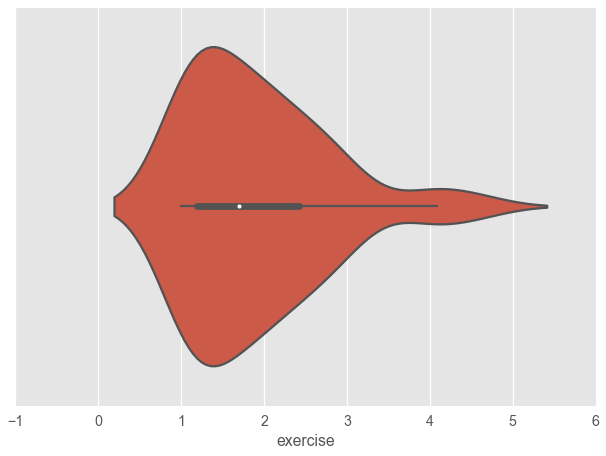

In [306]:
A = Exercise_df.groupby('id')['exercise'].mean()
sns.violinplot(A)

In [268]:
Exercise_df.resample('W',how='count')

,exercise,have,id,schedule,walk
resp_time,,,,,
2013-04-07,201,200,201,167,201
2013-04-14,123,123,123,105,123
2013-04-21,123,121,123,101,123
2013-04-28,90,88,90,78,90
2013-05-05,58,58,58,52,58
2013-05-12,38,38,38,34,38
2013-05-19,59,58,59,51,59
2013-05-26,26,26,26,25,25
2013-06-02,39,37,39,35,39


In [323]:
g = Exercise_df.groupby('id').resample('W',how='mean')
G = g.unstack()

G['mean'] = G.mean(axis=1)
G['num_resp'] = G.count(axis=1)

In [324]:
G.count(axis=1).describe()

count    46.00000
mean     23.73913
std      10.63419
min       6.00000
25%      14.00000
50%      22.00000
75%      34.00000
max      42.00000
dtype: float64

In [330]:
g.stack().unstack(level=1).reset_index(level=1)

resp_time,level_1,2013-04-07 00:00:00,2013-04-14 00:00:00,2013-04-21 00:00:00,2013-04-28 00:00:00,2013-05-05 00:00:00,2013-05-12 00:00:00,2013-05-19 00:00:00,2013-05-26 00:00:00,2013-06-02 00:00:00,2013-06-09 00:00:00
id,,,,,,,,,,,
u00,exercise,2.363636,1.000000,1.500000,2.500000,2.000000,1.0,1.750000,4.000000,1.800000,2.666667
u00,have,1.545455,2.000000,2.000000,1.500000,1.500000,2.0,2.000000,2.000000,1.500000,1.000000
u00,schedule,1.285714,1.000000,1.000000,1.000000,2.000000,1.0,1.000000,1.000000,1.333333,2.000000
u00,walk,2.181818,3.000000,1.500000,1.500000,3.000000,1.5,1.000000,1.000000,1.000000,1.333333
u01,exercise,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
u01,have,2.000000,2.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
u01,schedule,2.000000,2.000000,2.000000,2.000000,NaN,NaN,NaN,NaN,NaN,NaN
u01,walk,2.333333,1.000000,3.000000,3.000000,NaN,NaN,NaN,NaN,NaN,NaN
u02,exercise,2.333333,1.000000,2.000000,2.000000,1.000000,3.0,2.000000,NaN,NaN,NaN


In [311]:
G.shape

(46, 10)

In [296]:
G.loc['u59'].mean()

1.259259259259259

In [325]:
G

exercise                                          \
resp_time 2013-04-07 00:00:00 2013-04-14 00:00:00 2013-04-21 00:00:00   
id                                                                      
u00                  2.363636            1.000000            1.500000   
u01                  1.000000            1.000000            1.000000   
u02                  2.333333            1.000000            2.000000   
u03                  2.000000            2.000000                 NaN   
u04                  4.333333            4.000000            4.500000   
u07                  4.000000            3.000000            1.800000   
u08                  1.888889            1.166667            1.428571   
u10                  1.000000            2.250000            1.000000   
u12                  2.250000            1.500000                 NaN   
u14                  1.000000            1.000000            1.000000   
u15                       NaN            4.333333            5.000000   
u16                  2.142857            2.200000            2.333333   
u17                  1.000000            1.000000            1.571429   
u18                  3.666667            2.200000            2.000000   
u19                  3.000000            3.000000            3.833333   
u20                  2.000000            4.000000                 NaN   
u22                  1.857143            2.200000            3.000000   
u23                  1.000000            2.250000            1.000000   
u24                  1.750000            2.250000            1.000000   
u25                  4.666667            5.000000                 NaN   
u27                  1.000000                 NaN            1.000000   
u30                  1.000000            3.000000            1.000000   
u31                  2.800000                 NaN            3.333333   
u32                  1.000000            1.000000            2.000000   
u33                  1.000000            1.000000            1.000000   
u34                  2.000000                 NaN                 NaN   
u35                  1.000000            1.000000            1.000000   
u36                  2.166667            2.500000            3.000000   
u39                       NaN            1.000000            1.000000   
u41                  3.000000                 NaN                 NaN   
u42                  1.333333                 NaN                 NaN   
u43                  1.000000            1.000000            1.000000   
u44                  1.200000            1.000000            1.571429   
u45                  1.000000                 NaN                 NaN   
u46                  1.833333            2.333333            1.000000   
u47                  1.000000                 NaN            1.000000   
u49                  1.400000            1.000000            1.000000   
u50                  2.000000            2.000000                 NaN   
u51                  3.000000            3.000000            3.000000   
u52                  1.000000            1.000000            1.000000   
u53                  1.285714            1.000000            1.333333   
u54                  5.000000                 NaN                 NaN   
u56                       NaN            2.000000            1.000000   
u57                  3.833333            3.250000            2.500000   
u58                  4.000000            4.000000            3.000000   
u59                  1.333333            1.000000            1.000000   

                                                                       \
resp_time 2013-04-28 00:00:00 2013-05-05 00:00:00 2013-05-12 00:00:00   
id                                                                      
u00                  2.500000            2.000000            1.000000   
u01                  1.000000                 NaN                 NaN   
u02                  2.000000            1.000000            3.000000   
u03  

In [315]:
G.count(axis=0)

resp_time
2013-04-07    43
2013-04-14    38
2013-04-21    36
2013-04-28    36
2013-05-05    26
2013-05-12    21
2013-05-19    21
2013-05-26    12
2013-06-02    18
2013-06-09     3
dtype: int64

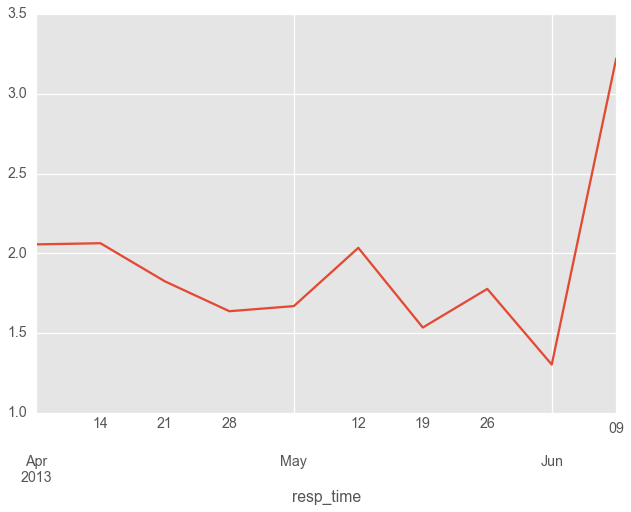

In [317]:
G.mean(axis=0).plot()

In [232]:
np.corrcoef(G['num_resp'],G['mean'])

array([[ 1.        ,  0.17547566],
       [ 0.17547566,  1.        ]])

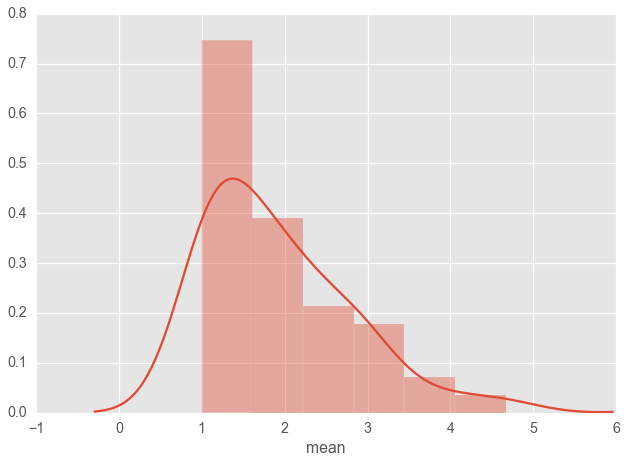

In [320]:
sns.distplot(G['mean'])

In [141]:
filename = os.path.join(EMA_root_directory,Question,Question+'.json')
print('filename:',filename)

filename: G:\Datasets\StudentLife\dataset\EMA\response\Exercise\Exercise.json


In [123]:

filename = filenames[0]

In [132]:
student_id = filename[-8:-5]

'u00'

In [118]:
pwd

'c:\\Users\\RMB\\Drive\\Tech Projects\\Data Science\\Omada Project'

In [73]:
json.load((open(file)))

[{'null': '1', 'resp_time': 1364452358},
 {'null': '2', 'resp_time': 1364586306},
 {'null': '1', 'resp_time': 1365142286},
 {'anxious': '1',
  'calm': '5',
  'conventional': '5',
  'critical': '1',
  'dependable': '3',
  'disorganized': '2',
  'enthusiastic': '3',
  'experiences': '3',
  'null': '5',
  'reserved': '5',
  'resp_time': 1366318497,
  'sympathetic': '3'}]

In [74]:
pd.read_json(file)

,anxious,calm,conventional,critical,dependable,disorganized,enthusiastic,experiences,null,reserved,resp_time,sympathetic
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2013-03-28 06:32:38,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,2013-03-29 19:45:06,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,2013-04-05 06:11:26,NaN
3,1,5,5,1,3,2,3,3,5,5,2013-04-18 20:54:57,3


In [61]:
A.loc[0]

name                                                    Social
questions    [{'options': '[1]0-4 persons, [2]5-9 persons, ...
Name: 0, dtype: object

In [64]:
import json

TypeError: list indices must be integers or slices, not str

In [110]:
EMA_root_directory = 'G:\Datasets\StudentLife\dataset\EMA\\response'
q = 2

In [88]:
user_id = '00'

'G:\\Datasets\\StudentLife\\dataset\\EMA\\response\\Sleep\\Sleep.json'

'G:\\Datasets\\StudentLife\\dataset\\EMA\\response\\Sleep'

In [108]:
json.load((open(filename)))

[{'level': '4',
  'location': '43.70685969,-72.28758714',
  'resp_time': 1364359545},
 {'null': '1', 'resp_time': 1364118420},
 {'null': '3', 'resp_time': 1364120323},
 {'null': '4', 'resp_time': 1364121003},
 {'null': '3', 'resp_time': 1364122102},
 {'level': '1',
  'location': '43.70677676,-72.28902977',
  'resp_time': 1364682446},
 {'level': '1',
  'location': '43.70652979,-72.28926963',
  'resp_time': 1364586325},
 {'level': '4',
  'location': '43.70685738,-72.28916538',
  'resp_time': 1364514789},
 {'level': '5',
  'location': '43.70672328,-72.28909919',
  'resp_time': 1364603578},
 {'level': '1',
  'location': '43.7067865,-72.28924896',
  'resp_time': 1364755767},
 {'level': '2',
  'location': '43.70656859,-72.28959788',
  'resp_time': 1364784354},
 {'level': '1',
  'location': '43.70671336,-72.28916672',
  'resp_time': 1364968984},
 {'level': '4',
  'location': '43.70654787,-72.28920771',
  'resp_time': 1365060515},
 {'level': '4',
  'location': '43.70712384,-72.28865547',
  're